<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/mlp/flax_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to neural networks using Flax



Flax / Linen is a neural net library, built on top of JAX, "designed to offer an implicit variable management API to save the user from having to manually thread thousands of variables through a complex tree of functions." To handle both current and future JAX transforms (configured and composed in any way), Linen Modules are defined as explicit functions of the form
$$
f(v_{in}, x) \rightarrow v_{out}, y
$$
Where $v_{in}$ is the collection of variables (eg. parameters) and PRNG state used by the model, $v_{out}$ the mutated output variable collections, $x$ the input data and $y$ the output data. We illustrate this below. Our tutorial is based on the official [flax intro](https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html) and [linen colab](https://github.com/google/flax/blob/master/docs/notebooks/linen_intro.ipynb). Details are in the [flax source code](https://flax.readthedocs.io/en/latest/_modules/index.html). Note: please be sure to read our [JAX tutorial](https://github.com/probml/pyprobml/blob/master/book1/intro/jax_intro.ipynb) first.


In [4]:
import numpy as np
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

In [ ]:
# Install the latest JAXlib version.
!pip install --upgrade -q pip jax jaxlib

     |████████████████████████████████| 34.0 MB 115 kB/s 


In [5]:
import jax
from jax import lax, random, numpy as jnp
key = random.PRNGKey(0)


In [6]:
from typing import Any, Callable, Dict, Iterator, Mapping, Optional, Sequence, Tuple

# Useful type aliases
Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any

In [7]:
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

In [8]:
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax import optim

from jax.config import config
config.enable_omnistaging() # Linen requires enabling omnistaging

# MLP in vanilla JAX

We construct a simple MLP with L hidden layers (relu activation), and scalar output (linear activation).

Note: JAX and Flax, like NumPy, are row-based systems, meaning that vectors are represented as row vectors and not column vectors. 


In [ ]:
# We define the parameter initializers using a signature that is flax-compatible
# https://flax.readthedocs.io/en/latest/_modules/jax/_src/nn/initializers.html

def weights_init(key, shape, dtype=jnp.float32):
  return random.normal(key, shape, dtype)
  #return jnp.ones(shape, dtype)

def bias_init(key, shape, dtype=jnp.float32):
  return jnp.zeros(shape, dtype)

def relu(a):
  return jnp.maximum(a, 0)

In [ ]:
# A minimal MLP class

class MLP0():
  features: Sequence[int] # number of features in each layer

  def __init__(self, features): # class constructor
    self.features = features

  def init(self, key, x): # initialize parameters
    in_size = np.shape(x)[1]
    sizes = np.concatenate( ([in_size], self.features) )
    nlayers = len(sizes)
    params = {}
    for i in range(nlayers-1):
      in_size = sizes[i]
      out_size = sizes[i+1]
      subkey1, subkey2, key = random.split(key, num=3)
      W = weights_init(subkey1, (in_size, out_size) )
      b = bias_init(subkey2, out_size)
      params[f'W{i}'] = W
      params[f'b{i}'] = b
    return params

  def apply(self, params, x): # forwards pass
    activations = x
    nhidden_layers = len(self.features)-1
    for i in range(nhidden_layers):
      W = params[f'W{i}']; b = params[f'b{i}'];
      outputs = jnp.dot(activations, W) + b
      activations = relu(outputs)
    # for final layer, no activation function
    i = nhidden_layers
    outputs = jnp.dot(activations, params[f'W{i}']) + params[f'b{i}']
    return outputs



In [ ]:
key = random.PRNGKey(0)
D = 3
N = 2
x = random.normal(key, (N,D,))
layer_sizes = [3,1] # 1 hidden layer of size 3, 1 scalar output


model0 = MLP0(layer_sizes)
params0 = model0.init(key, x)

print('params')
for k,v in params0.items():
  print(k, v.shape)
  print(v)

y0 = model0.apply(params0, x)
print('\noutput')
print(y0)

params
W0 (3, 3)
[[-1.83021 1.18417 0.06777]
 [0.34588 0.37858 -0.65318]
 [0.18976 0.45157 -0.33964]]
b0 (3,)
[0.00000 0.00000 0.00000]
W1 (3, 1)
[[-1.74905]
 [1.83313]
 [-0.23808]]
b1 (1,)
[0.00000]

output
[[-0.09538]
 [2.78382]]


# Our first flax model

Here we recreate the vanilla model in flax. Since we don't specify how the parameters are initialized, the behavior will not be identical to the vanilla model --- we will fix this below, but for now, we focus on model construction.

We see that the model is a subclass of `nn.Module`, which is a subclass of Python's dataclass. The child class (written by the user) must define a `model.call(inputs)` method, that applies the function to the input, and a `model.setup()` method, that creates the modules inside this model.

The module (parent) class defines two main methods: `model.apply(variables, input`, that applies the function to the input (and variables) to generate an output; and `model.init(key, input)`, that initializes the variables and returns them as a "frozen dictionary". This dictionary can contain multiple *kinds* of variables. In the example below, the only kind are parameters, which are immutable variables (that will usually get updated in an external optimization loop, as we show later). The parameters are  automatically named after the corresponding module (here, dense0, dense1, etc).  In this example, both modules are dense layers, so their parameters are a weight matrix (called 'kernel') and a bias vector.

The hyper-parameters (in this case, the size of each layer) are stored as attributes of the class, and are specified when the module is constructed.

In [ ]:
class MLP(nn.Module):
  features: Sequence[int]
  default_attr: int = 42

  def setup(self):
    print('setup')
    self.layers = [nn.Dense(feat) for feat in self.features]

  def __call__(self, inputs):
    print('call')
    x = inputs
    for i, lyr in enumerate(self.layers):
      x = lyr(x)
      if i != len(self.layers) - 1:
        x = nn.relu(x)
    return x



In [ ]:
key = random.PRNGKey(0)
D = 3
N = 2
x = random.normal(key, (N,D,))
layer_sizes = [3,1] # 1 hidden layer of size 3, 1 scalar output

print('calling constructor')
model = MLP(layer_sizes) # just initialize attributes of the object
print('OUTPUT')
print(model)

print('\ncalling init')
variables = model.init(key, x)  # calls setup then __call___
print('OUTPUT')
print(variables)

print('\nW0')
W0 = variables['params']['layers_0']['kernel']
print(W0)

print('Calling apply')
y = model.apply(variables, x) # calls setup then __call___
print(y)

calling constructor
OUTPUT
MLP(
    # attributes
    features = [3, 1]
    default_attr = 42
)

calling init
setup
call
OUTPUT
FrozenDict({
    params: {
        layers_0: {
            kernel: DeviceArray([[0.57725, 0.43926, 0.69045],
                         [0.02542, 0.50461, 0.56675],
                         [0.07185, 0.17350, -0.04227]], dtype=float32),
            bias: DeviceArray([0.00000, 0.00000, 0.00000], dtype=float32),
        },
        layers_1: {
            kernel: DeviceArray([[0.24313],
                         [0.94535],
                         [-0.12602]], dtype=float32),
            bias: DeviceArray([0.00000], dtype=float32),
        },
    },
})

W0
[[0.57725 0.43926 0.69045]
 [0.02542 0.50461 0.56675]
 [0.07185 0.17350 -0.04227]]
Calling apply
setup
call
[[0.02978]
 [0.66403]]


# Compact modules

To reduce the amount of boiler plate code, flax makes it possible to define a module just by writing the `call` method, avoiding the need to write a `setup` function. The corresponding layers will be created when the `init` funciton is called, so the input shape can be inferred lazily (when passed an input). 

In [ ]:
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      x = nn.Dense(feat)(x)
      if i != len(self.features) - 1:
        x = nn.relu(x)
    return x


model = MLP(layer_sizes)
print(model)

params = model.init(key, x)
print(params)

y = model.apply(params, x)
print(y)

MLP(
    # attributes
    features = [3, 1]
)
FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[0.28216, 1.03322, 0.07901],
                         [0.15159, -0.50100, -0.22373],
                         [-0.40327, -0.39875, -0.09402]], dtype=float32),
            bias: DeviceArray([0.00000, 0.00000, 0.00000], dtype=float32),
        },
        Dense_1: {
            kernel: DeviceArray([[0.25432],
                         [0.76792],
                         [0.48329]], dtype=float32),
            bias: DeviceArray([0.00000], dtype=float32),
        },
    },
})
[[0.56035]
 [1.07065]]


# Explicit parameter initialization

We can control the initialization of the random parameters in each submodule by specifying an init function. Below we show how to initialize our MLP to match the vanilla JAX model. We then check both methods give the same outputs.

In [ ]:
def make_const_init(x):
  def init_params(key, shape, dtype=jnp.float32):
    return x
  return init_params

class MLP_init(nn.Module):
  features: Sequence[int]
  params_init: Dict

  def setup(self):
    nlayers = len(self.features)
    layers = []
    for i in range(nlayers):
      W = self.params_init[f'W{i}'];
      b = self.params_init[f'b{i}']; 
      weights_init = make_const_init(W)
      bias_init = make_const_init(b)
      layer = nn.Dense(self.features[i], kernel_init=weights_init, bias_init=bias_init)
      layers.append(layer)
    self.layers = layers

  def __call__(self, inputs):
    x = inputs
    for i, lyr in enumerate(self.layers):
      x = lyr(x)
      if i != len(self.layers) - 1:
        x = nn.relu(x)
    return x

params_init = params0
model = MLP_init(layer_sizes, params_init)
print(model)

params = model.init(key, x)
print(params)

y = model.apply(params, x)
print(y)

assert np.allclose(y, y0)

MLP_init(
    # attributes
    features = [3, 1]
    params_init = {'W0': DeviceArray([[-1.83021, 1.18417, 0.06777],
                 [0.34588, 0.37858, -0.65318],
                 [0.18976, 0.45157, -0.33964]], dtype=float32), 'b0': DeviceArray([0.00000, 0.00000, 0.00000], dtype=float32), 'W1': DeviceArray([[-1.74905],
                 [1.83313],
                 [-0.23808]], dtype=float32), 'b1': DeviceArray([0.00000], dtype=float32)}
)
FrozenDict({
    params: {
        layers_0: {
            kernel: DeviceArray([[-1.83021, 1.18417, 0.06777],
                         [0.34588, 0.37858, -0.65318],
                         [0.18976, 0.45157, -0.33964]], dtype=float32),
            bias: DeviceArray([0.00000, 0.00000, 0.00000], dtype=float32),
        },
        layers_1: {
            kernel: DeviceArray([[-1.74905],
                         [1.83313],
                         [-0.23808]], dtype=float32),
            bias: DeviceArray([0.00000], dtype=float32),
        },
    },
})
[

# Nested modules

We can embed an MLP inside an MLP.

In [ ]:
class MLP_nested(nn.Module):
    features_nested: Sequence[int]
    features_output: int

    def setup(self):
      self.mlp = MLP(self.features_nested)
      self.output_layer = nn.Dense(self.features_output)

    def __call__(self, x):
      return self.output_layer(nn.relu(self.mlp(x)))


model = MLP_nested([3,4], 1)
print(model)

params = model.init(key, x)
print(params)

y = model.apply(params, x)
print(y)


MLP_nested(
    # attributes
    features_nested = [3, 4]
    features_output = 1
)
FrozenDict({
    params: {
        mlp: {
            Dense_0: {
                kernel: DeviceArray([[-0.63572, 0.33321, 0.62651],
                             [-0.17779, 0.22005, 0.74431],
                             [-0.97726, -0.47203, 0.43659]], dtype=float32),
                bias: DeviceArray([0.00000, 0.00000, 0.00000], dtype=float32),
            },
            Dense_1: {
                kernel: DeviceArray([[0.22112, 0.87654, 0.22310, -1.22264],
                             [-0.32240, 0.94956, -0.04660, 0.39572],
                             [-0.03547, -0.75176, 0.35311, 0.59318]], dtype=float32),
                bias: DeviceArray([0.00000, 0.00000, 0.00000, 0.00000], dtype=float32),
            },
        },
        output_layer: {
            kernel: DeviceArray([[0.08588],
                         [0.64215],
                         [-0.46796],
                         [-0.10338]], dtype=f

We can also use the compact notation. The resulting parameters have slightly different names, and random initial values. (They can be made the same, of course.)

In [ ]:
class MLP_nested(nn.Module):
    features_nested: Sequence[int]
    features_output: int

    @nn.compact
    def __call__(self, x):
      mlp = MLP(self.features_nested, name="my_nested_MLP")
      dense = nn.Dense(self.features_output)
      return dense(nn.relu(mlp(x)))

model = MLP_nested([3,4], 1)

params = model.init(key, x)
print(params)

y = model.apply(params, x)
print(y)

FrozenDict({
    params: {
        my_nested_MLP: {
            Dense_0: {
                kernel: DeviceArray([[-0.22084, -0.04334, -0.92993],
                             [-0.42234, 0.45470, -0.09518],
                             [0.86117, 0.10712, 0.50940]], dtype=float32),
                bias: DeviceArray([0.00000, 0.00000, 0.00000], dtype=float32),
            },
            Dense_1: {
                kernel: DeviceArray([[-0.17214, -0.46445, 0.01060, -0.84916],
                             [0.56824, 0.08029, 0.90197, -0.04891],
                             [0.65304, 0.74382, 0.71842, 0.96025]], dtype=float32),
                bias: DeviceArray([0.00000, 0.00000, 0.00000, 0.00000], dtype=float32),
            },
        },
        Dense_0: {
            kernel: DeviceArray([[0.88803],
                         [-0.85732],
                         [0.13939],
                         [0.10748]], dtype=float32),
            bias: DeviceArray([0.00000], dtype=float32),
        },
   

# Creating modules with parameters

Now we illustrate how to create a module with its own parameters, instead of relying on composing built-in primitives. As an example, we write our own dense layer class.

In [ ]:
class SimpleDense(nn.Module):
  features: int # num output features for this layer
  kernel_init: Callable = nn.initializers.lecun_normal()
  bias_init: Callable = nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    features_in = inputs.shape[-1] # infer shape from input
    features_out = self.features
    kernel = self.param('kernel', self.kernel_init, (features_in, features_out))
    bias = self.param('bias', self.bias_init, (features_out,))
    outputs = jnp.dot(inputs, kernel) + bias
    return outputs


model = SimpleDense(features=3)
print(model)

params = model.init(key, x)
print(params)

y = model.apply(params, x)
print(y)

SimpleDense(
    # attributes
    features = 3
    kernel_init = init
    bias_init = zeros
)
FrozenDict({
    params: {
        kernel: DeviceArray([[0.32718, 0.05599, 0.17998],
                     [-0.12295, 0.70712, 0.28972],
                     [0.13731, -0.02853, -0.62830]], dtype=float32),
        bias: DeviceArray([0.00000, 0.00000, 0.00000], dtype=float32),
    },
})
[[0.30842 -0.91549 -0.74603]
 [0.36248 0.24616 0.36943]]


# Stochastic layers

Some layers may need a source of randomness. If so, we must pass them a PRNG in the `init` and `apply` functions, in addition to the PRNG used for parameter initialization. We illustrate this below using dropout. We construct two versions, one which is stochastic (for training), and one which is deterministic (for evaluation). 

In [ ]:
class Block(nn.Module):
  features: int
  training: bool
  @nn.compact
  def __call__(self, inputs):
    x = nn.Dense(self.features)(inputs)
    x = nn.Dropout(rate=0.5)(x, deterministic=not self.training)
    return x

N = 1; D = 2;
x = random.uniform(key, (N,D))

model = Block(features=3, training=True)
key = random.PRNGKey(0)
variables = model.init({'params': key, 'dropout': key}, x)
#variables = model.init(key, x) # cannot share the rng
print('variables', variables)

# Apply stochastic model
for i in range(2):
  key, subkey = random.split(key)
  y = model.apply(variables, x, rngs={'dropout': subkey})
  print(f'train output {i}, ', y)

# Now make a deterministic version
eval_model = Block(features=3, training=False)
key = random.PRNGKey(0)
#variables = eval_model.init({'params': key, 'dropout': key}, x)
for i in range(2):
  key, subkey = random.split(key)
  y = eval_model.apply(variables, x, rngs={'dropout': subkey})
  print(f'eval output {i}, ', y)



variables FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[0.99988, -0.14086, -0.99796],
                         [1.46673, 0.59637, 0.38263]], dtype=float32),
            bias: DeviceArray([0.00000, 0.00000, 0.00000], dtype=float32),
        },
    },
})
train output 0,  [[0.00000 1.05814 0.00000]]
train output 1,  [[3.12202 1.05814 0.32862]]
eval output 0,  [[1.56101 0.52907 0.16431]]
eval output 1,  [[1.56101 0.52907 0.16431]]


# Mutable variables

In addition to parameters, linen modules can contain other kinds of variables, which may be mutable as we illustrate below.
Indeed, parameters are just a special case of variable.
In particular, this line
```
p = self.param('param_name', init_fn, shape, dtype)
```
is a convenient shorthand for this:
```
p = self.variable('params', 'param_name', lambda s, d: init_fn(self.make_rng('params'), s, d), shape, dtype).value
```


## Example: counter

In [ ]:
class Counter(nn.Module):
  @nn.compact
  def __call__(self):
    # variable(collection, name, init_fn, *init_args)
    counter1 = self.variable('counter', 'count1', lambda: jnp.zeros((), jnp.int32))
    counter2 = self.variable('counter', 'count2', lambda: jnp.zeros((), jnp.int32))
    is_initialized = self.has_variable('counter', 'count1')
    if is_initialized:
      counter1.value += 1
      counter2.value += 2
    return counter1.value, counter2.value


model = Counter()
print(model)

init_variables = model.init(key) # calls the `call` method
print('initialized variables:\n', init_variables)
counter = init_variables['counter']['count1']
print('counter 1 value', counter)

y, mutated_variables = model.apply(init_variables, mutable=['counter'])
print('mutated variables:\n', mutated_variables)
print('output:\n', y)

Counter()
initialized variables:
 FrozenDict({
    counter: {
        count1: DeviceArray(1, dtype=int32),
        count2: DeviceArray(2, dtype=int32),
    },
})
counter 1 value 1
mutated variables:
 FrozenDict({
    counter: {
        count1: DeviceArray(2, dtype=int32),
        count2: DeviceArray(4, dtype=int32),
    },
})
output:
 (DeviceArray(2, dtype=int32), DeviceArray(4, dtype=int32))


## Combining mutable variables and immutable parameters

We can combine mutable variables with immutable parameters.
As an example, consider a simplified version of batch normalization, which 
 computes the running mean of its inputs, and adds an optimzable offset (bias) term. 



In [ ]:
class BiasAdderWithRunningMean(nn.Module):
  decay: float = 0.99

  @nn.compact
  def __call__(self, x):
    is_initialized = self.has_variable('params', 'bias')

    # variable(collection, name, init_fn, *init_args)
    ra_mean = self.variable('batch_stats', 'mean', lambda s: jnp.zeros(s), x.shape[1:])

    dummy_mutable = self.variable('mutables', 'dummy', lambda s: 42, 0)

    # param(name, init_fn, *init_args)
    bias = self.param('bias', lambda rng, shape: jnp.ones(shape), x.shape[1:]) 

    if is_initialized:
      ra_mean.value = self.decay * ra_mean.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)

    return x - ra_mean.value + bias




The intial variables are:
params = (bias=1), batch_stats=(mean=0)

If we pass in x=ones(N,D), the  running average becomes
$$
0.99*0 + (1-0.99)*1 = 0.01
$$
and the output becomes
$$
1 - 0.01 + 1 = 1.99
$$




In [ ]:
key = random.PRNGKey(0)
N = 2
D = 5
x = jnp.ones((N,D))
model = BiasAdderWithRunningMean()

variables = model.init(key, x)
print('initial variables:\n', variables)
nonstats, stats = variables.pop('batch_stats')
print('nonstats', nonstats)
print('stats', stats)


initial variables:
 FrozenDict({
    batch_stats: {
        mean: DeviceArray([0.00000, 0.00000, 0.00000, 0.00000, 0.00000], dtype=float32),
    },
    mutables: {
        dummy: 42,
    },
    params: {
        bias: DeviceArray([1.00000, 1.00000, 1.00000, 1.00000, 1.00000], dtype=float32),
    },
})
nonstats FrozenDict({
    mutables: {
        dummy: 42,
    },
    params: {
        bias: DeviceArray([1.00000, 1.00000, 1.00000, 1.00000, 1.00000], dtype=float32),
    },
})
stats FrozenDict({
    mean: DeviceArray([0.00000, 0.00000, 0.00000, 0.00000, 0.00000], dtype=float32),
})


In [ ]:
y, mutables = model.apply(variables, x, mutable=['batch_stats'])
print('output', y)
print('mutables', mutables)

output [[1.99000 1.99000 1.99000 1.99000 1.99000]
 [1.99000 1.99000 1.99000 1.99000 1.99000]]
mutables FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.01000, 0.01000, 0.01000, 0.01000, 0.01000]], dtype=float32),
    },
})


To call the function with the updated batch stats, we have to stitch together the new mutated state with the old state, as shown below.



In [ ]:

variables = unfreeze(nonstats)
print(variables)
variables['batch_stats'] = mutables['batch_stats']
variables = freeze(variables)
print(variables)

{'mutables': {'dummy': 42}, 'params': {'bias': DeviceArray([1.00000, 1.00000, 1.00000, 1.00000, 1.00000], dtype=float32)}}
FrozenDict({
    mutables: {
        dummy: 42,
    },
    params: {
        bias: DeviceArray([1.00000, 1.00000, 1.00000, 1.00000, 1.00000], dtype=float32),
    },
    batch_stats: {
        mean: DeviceArray([[0.01000, 0.01000, 0.01000, 0.01000, 0.01000]], dtype=float32),
    },
})


If we pass in x=2*ones(N,D), the running average gets updated to
$$
0.99 * 0.01 + (1-0.99) * 2.0 = 0.0299
$$
and the output becomes
$$
2- 0.0299 + 1 = 2.9701
$$

In [ ]:

x = 2*jnp.ones((N,D))
y, mutables = model.apply(variables, x, mutable=['batch_stats'])
print('output', y)
print('batch_stats', mutables)

assert np.allclose(y, 2.9701)
assert np.allclose(mutables['batch_stats']['mean'], 0.0299)

output [[2.97010 2.97010 2.97010 2.97010 2.97010]
 [2.97010 2.97010 2.97010 2.97010 2.97010]]
batch_stats FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.02990, 0.02990, 0.02990, 0.02990, 0.02990]], dtype=float32),
    },
})


# Optimization

Flax has several built-in (first-order) optimizers, as we illustrate below on a random linear function. (Note that we can also fit a model defined in flax using some other kind of optimizer, such as that provided by the [optax library](https://github.com/deepmind/optax).)

In [ ]:
D = 5
key = jax.random.PRNGKey(0)
params = {'w': jax.random.normal(key, (D,))}
print(params)

x = jax.random.normal(key, (D,))

def loss(params):
  w = params['w']
  return jnp.dot(x, w)

loss_grad_fn = jax.value_and_grad(loss)
v, g = loss_grad_fn(params)
print(v)
print(g)

{'w': DeviceArray([0.18784, -1.28334, -0.27109, 1.24906, 0.24447], dtype=float32)}
3.375659
{'w': DeviceArray([0.18784, -1.28334, -0.27109, 1.24906, 0.24447], dtype=float32)}


In [ ]:
from flax import optim
optimizer_def = optim.Momentum(learning_rate=0.1, beta=0.9)
print(optimizer_def)

optimizer = optimizer_def.create(params) 
print(optimizer)

Optimizer(optimizer_def=<flax.optim.momentum.Momentum object at 0x7fbd09abceb8>, state=OptimizerState(step=DeviceArray(0, dtype=int32), param_states={'w': _MomentumParamState(momentum=DeviceArray([0.00000, 0.00000, 0.00000, 0.00000, 0.00000], dtype=float32))}), target={'w': DeviceArray([0.18784, -1.28334, -0.27109, 1.24906, 0.24447], dtype=float32)})


In [ ]:
for i in range(10):
  params = optimizer.target
  loss_val, grad = loss_grad_fn(params)
  optimizer = optimizer.apply_gradient(grad)
  params = optimizer.target
  print('step {}, loss {:0.3f}, params {}'.format(i, loss_val, params))

step 0, loss -10.593, params {'w': DeviceArray([-0.71837, 4.90788, 1.03673, -4.77677, -0.93493], dtype=float32)}
step 1, loss -12.910, params {'w': DeviceArray([-0.85316, 5.82877, 1.23126, -5.67306, -1.11035], dtype=float32)}
step 2, loss -15.332, params {'w': DeviceArray([-0.99326, 6.78590, 1.43345, -6.60462, -1.29268], dtype=float32)}
step 3, loss -17.849, params {'w': DeviceArray([-1.13813, 7.77566, 1.64252, -7.56794, -1.48122], dtype=float32)}
step 4, loss -20.453, params {'w': DeviceArray([-1.28730, 8.79477, 1.85780, -8.55983, -1.67536], dtype=float32)}
step 5, loss -23.133, params {'w': DeviceArray([-1.44033, 9.84031, 2.07866, -9.57743, -1.87453], dtype=float32)}
step 6, loss -25.884, params {'w': DeviceArray([-1.59685, 10.90963, 2.30454, -10.61818, -2.07823], dtype=float32)}
step 7, loss -28.696, params {'w': DeviceArray([-1.75650, 12.00035, 2.53494, -11.67977, -2.28600], dtype=float32)}
step 8, loss -31.565, params {'w': DeviceArray([-1.91897, 13.11033, 2.76941, -12.76010, -2.4

# Worked example: MLP for MNIST 

We demonstrate how to fit a shallow MLP to MNIST using Flax.
We use this function:
https://github.com/probml/pyprobml/blob/master/scripts/fit_flax.py
To allow us to edit this file locally (in colab), and push commits back to github, we sync this colab with github. (For details see [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/intro/colab_intro.ipynb), the cell labeled "Working with github".)



## Import code

In [1]:
!ls

sample_data


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/ssh/

Mounted at /content/drive
id_rsa	id_rsa.pub  known_hosts


In [9]:
!rm -rf git_colab*.*
!wget https://raw.githubusercontent.com/probml/pyprobml/master/scripts/git_colab.py   
import git_colab as gc

--2021-01-19 21:52:51--  https://raw.githubusercontent.com/probml/pyprobml/master/scripts/git_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1243 (1.2K) [text/plain]
Saving to: ‘git_colab.py’

git_colab.py        100%[===================>]   1.21K  --.-KB/s    in 0s      

2021-01-19 21:52:51 (57.6 MB/s) - ‘git_colab.py’ saved [1243/1243]



In [10]:

!rm -rf pyprobml
gc.git_ssh("git clone https://github.com/probml/pyprobml.git")


executing command via ssh: git clone git@github.com:probml/pyprobml.git


In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
from google.colab import files
files.view('/content/pyprobml/scripts/fit_flax.py')

<IPython.core.display.Javascript object>

In [20]:
import pyprobml.scripts.fit_flax as ff
ff.test()

testing fit-flax
train step: 0, loss: 1.9384, accuracy: 0.00
train step: 1, loss: 1.8272, accuracy: 0.33
FrozenDict({
    Dense_0: {
        bias: DeviceArray([-0.06866, -0.05334, 0.02114, 0.03266, 0.01460, 0.02043,
                     0.03476, 0.03221, 0.04559, -0.07938], dtype=float32),
        kernel: DeviceArray([[-0.08550, -0.05451, 0.00159, 0.01994, 0.00922, 0.01030,
                      0.02837, 0.02299, 0.01819, 0.02941],
                     [0.10214, -0.07613, -0.01284, -0.00828, -0.00770, -0.00438,
                      -0.02352, -0.00740, -0.03010, 0.06821],
                     [0.10793, 0.00674, 0.00768, -0.00738, -0.00527, -0.00135,
                      -0.02333, -0.01150, -0.00446, -0.06905],
                     [-0.01783, -0.02995, 0.00988, 0.01451, 0.00608, 0.00938,
                      0.01329, 0.01404, 0.01951, -0.03890],
                     [-0.02009, 0.03532, 0.01935, 0.01093, 0.00620, 0.00832,
                      0.01147, 0.00773, 0.03048, -0.10972]], dty

Edit the file, then commit changes.

In [49]:
# If made any local changes to fit_flax.py, save them to github
%cd /content/pyprobml
gc.git_ssh("git add scripts; git commit -m 'push from colab'; git push")
%cd /content

/content/pyprobml
executing command: git add scripts; git commit -m 'push from colab'; git push
# github.com:22 SSH-2.0-babeld-ccb88c3b
Hi murphyk! You've successfully authenticated, but GitHub does not provide shell access.
[master 7002db7] push from colab
 3 files changed, 42 insertions(+), 28 deletions(-)
 create mode 100644 scripts/__pycache__/__init__.cpython-36.pyc
 create mode 100644 scripts/__pycache__/fit_flax.cpython-36.pyc
Counting objects: 7, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 3.68 KiB | 3.68 MiB/s, done.
Total 7 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To github.com:probml/pyprobml.git
   18f72a1..7002db7  master -> master
/content


## Data

In [49]:

#train_data = train_data.map(lambda image: tf.image.resize_image_with_crop_or_pad(image, 224, 224))

def process_batch(batch):
  images = batch['image']
  labels = batch['label']
  # flatten single image
  shape = images.get_shape().as_list()
  D = np.prod(shape)
  images = tf.reshape(images, (D,))
  #images = tf.squeeze(images, axis=[-1]) # convert to N*D where D=28*28
  images = tf.cast(images, dtype=tf.float32)
  images = ((images / 255.) - .5) * 2. # rescale to -1..1
  return {'X': images, 'y': labels} # convert to standard name

def load_mnist(split, batch_size):
  dataset, info = tfds.load("mnist", split=split, with_info=True)
  dataset = dataset.map(process_batch)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  dataset = dataset.cache().repeat()
  if split=="train":
    dataset = dataset.shuffle(10*batch_size, seed=0)
  dataset = tfds.as_numpy(dataset) # bye bye TF land
  num_examples = info.splits[split].num_examples
  return iter(dataset), num_examples


batch_size = 100
train_iter, num_train = load_mnist("train", batch_size)
test_iter, num_test = load_mnist("test", batch_size)

num_epochs = 3
num_steps = num_train // batch_size 
print(f'{num_epochs} epochs with batch size {batch_size} will take {num_steps} steps')

batch = next(train_iter)
print(batch['X'].shape)
print(batch['y'].shape)

3 epochs with batch size 100 will take 600 steps
(100, 784)
(100,)


## Model



In [39]:
class Model(nn.Module):
  nhidden: int
  nclasses: int

  @nn.compact
  def __call__(self, x):
    if self.nhidden > 0:
      x = nn.Dense(self.nhidden)(x)
      x = nn.relu(x)
    x = nn.Dense(self.nclasses)(x) # logits
    x = nn.log_softmax(x) # log probabilities
    return x


## Training loop


In [51]:


model = Model(nhidden = 128, nclasses=10) 
rng = jax.random.PRNGKey(0)
num_steps = 200

params, history =  ff.fit_model(
    model, rng, num_steps, train_iter, test_iter, print_every=20)
  
display(history)

train step: 0, loss: 2.4430, accuracy: 0.09
train step: 20, loss: 1.1147, accuracy: 0.60
train step: 40, loss: 0.3219, accuracy: 0.92
train step: 60, loss: 0.5857, accuracy: 0.81
train step: 80, loss: 0.7218, accuracy: 0.75
train step: 100, loss: 0.5993, accuracy: 0.81
train step: 120, loss: 0.2716, accuracy: 0.93
train step: 140, loss: 0.4771, accuracy: 0.83
train step: 160, loss: 0.3512, accuracy: 0.89
train step: 180, loss: 0.5115, accuracy: 0.86


,train_loss,train_accuracy,test_loss,test_accuracy,step
0,2.442956,0.089999996,2.9638493,0.089999996,0.0
1,1.1147307,0.59999996,1.0728567,0.59999996,20.0
2,0.32193664,0.91999996,0.87930954,0.77,40.0
3,0.58570653,0.81,0.5977443,0.78999996,60.0
4,0.7217762,0.75,0.83044803,0.74,80.0
5,0.5992826,0.81,0.7542707,0.78,100.0
6,0.2716312,0.93,0.63344413,0.87,120.0
7,0.47708598,0.83,0.62958264,0.75,140.0
8,0.35116953,0.89,0.50654083,0.84,160.0
9,0.51153046,0.85999995,0.3848496,0.89,180.0


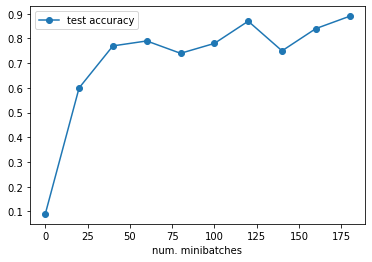

In [52]:
plt.figure()
plt.plot(history['step'], history['test_accuracy'], 'o-', label='test accuracy')
plt.xlabel('num. minibatches')
plt.legend()
plt.show()